<a href="https://colab.research.google.com/github/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Negation_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment.git@master#egg=multitask_negation_target

In [2]:
from typing import List, Dict
from collections import defaultdict
from pathlib import Path
import tempfile

import requests
from sklearn.metrics import accuracy_score, f1_score
from multitask_negation_target.analysis import evaluation_metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

ROW_ORDER=['Test', 'Validation']
DATASET_ORDER = ['Laptop', 'Restaurant']
HUE_ORDER = ['STL', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (CD)', 
             'MTL (SFU)', 'MTL (SPEC)']

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

def create_twin_plot(data_df: pd.DataFrame) -> List[plt.Axes]:
  fig, axes = plt.subplots(1,2,figsize=(15, 5))
  dataset_list_order = ['Restaurant', 'Laptop']
  METRIC_ORDER = ['F1-i', 'Acc-s', 'F1-s', 'F1-a']
  for col_index, dataset_name in enumerate(dataset_list_order):
    df = data_df[data_df['Dataset']==dataset_name]
    axes[col_index] = sns.pointplot(join=False, dodge=0.8, ci='sd', y='Score', 
                                    hue='Model', x='Metric', data=df,
                                    hue_order=HUE_ORDER, order=METRIC_ORDER,
                                    ax=axes[col_index])
    axes[col_index].set_title(f'{dataset_name}')
    if col_index != 0:
      axes[col_index].set_ylabel('')
    if col_index != 0:
      axes[col_index].get_legend().remove()
    else:
      axes[col_index].legend(ncol=7, borderaxespad=0., 
                             bbox_to_anchor=(0.3, 1.1), loc='lower left')
  return axes

def get_negated_data(filtered: bool, cwr: bool = False) -> Dict:
  negation_results_df_dict = defaultdict(list)

  base_url = 'https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en'
  model_names = ['STL', 'MTL (CD)', 'MTL (SFU)', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (SPEC)']
  dataset_names = ['Restaurant', 'Laptop', 'MAMS']
  split_names = ['Validation', 'Test']
  dataset_name_mapper = {f'{name}_contextualized': name for name in dataset_names}
  if cwr:
    dataset_names = [f'{name}_contextualized' for name in dataset_names]

  for model_name in model_names:
    if model_name == 'STL':
      model_url = base_url + '/stl'
    elif model_name == 'MTL (CD)':
      model_url = base_url + '/mtl/conan_doyle'
    elif model_name == 'MTL (SFU)':
      model_url = base_url + '/mtl/sfu'
    elif model_name == 'MTL (SPEC)':
      model_url = base_url + '/mtl/sfu_spec'
    elif model_name == 'MTL (DR)':
      model_url = base_url + '/mtl/dr'
    elif model_name == 'MTL (LEX)':
      model_url = base_url + '/mtl/lextag'
    elif model_name == 'MTL (UPOS)':
      model_url = base_url + '/mtl/u_pos'
    for dataset_name in dataset_names:
      for split_name in split_names:
        if split_name == 'Test':
          result_url = model_url + f'/{dataset_name.lower()}/test_neg.conll'
          if filtered:
            result_url = model_url + f'/{dataset_name.lower()}/test_neg_only.conll'
          if dataset_name == 'MAMS' or dataset_name == 'MAMS_contextualized':
            result_url = model_url + f'/{dataset_name}/test_neg.conll'
            if filtered:
              result_url = model_url + f'/{dataset_name}/test_neg_only.conll'
        elif split_name == 'Validation':
          result_url = model_url + f'/{dataset_name.lower()}/dev_neg.conll'
          if filtered:
            result_url = model_url + f'/{dataset_name.lower()}/dev_neg_only.conll'
          if dataset_name == 'MAMS' or dataset_name == 'MAMS_contextualized':
            result_url = model_url + f'/{dataset_name}/dev_neg.conll'
            if filtered:
              result_url = model_url + f'/{dataset_name}/dev_neg_only.conll'
        else:
          raise ValueError(f'Can only be Test or Validation split and not {split_name}')
        
        for run_number in range(5):
          with tempfile.TemporaryDirectory() as temp_dir:
            temp_fp = Path(temp_dir, 'temp_file.txt')
            with temp_fp.open('w') as temp_file:
              temp_file.write(requests.get(result_url).text)
            f1_a = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=True)
            f1_a_recall, f1_a_precision, f1_a = f1_a
            f1_i = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=False)
            f1_i_recall, f1_i_precision, f1_i = f1_i
            f1_i_pos = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment='POS')
            f1_i_pos_recall, f1_i_pos_precision, f1_i_pos = f1_i_pos
            f1_i_neu = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment='NEU')
            f1_i_neu_recall, f1_i_neu_precision, f1_i_neu = f1_i_neu
            f1_i_neg = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                  ignore_sentiment=False, 
                                                  filter_by_sentiment='NEG') 
            f1_i_neg_recall, f1_i_neg_precision, f1_i_neg = f1_i_neg
            f1_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number, 
                                                        metric_func=f1_score, 
                                                        average='macro')
            acc_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number,
                                                        metric_func=accuracy_score)
            if cwr:
              negation_results_df_dict['CWR'].append(True)
            else:
              negation_results_df_dict['CWR'].append(False)
            negation_results_df_dict['Model'].append(model_name)
            if dataset_name in dataset_name_mapper:
              negation_results_df_dict['Dataset'].append(dataset_name_mapper[dataset_name])
            else:
              negation_results_df_dict['Dataset'].append(dataset_name)
            negation_results_df_dict['Run'].append(run_number)
            negation_results_df_dict['Split'].append(split_name)
            negation_results_df_dict['F1-a'].append(f1_a)
            negation_results_df_dict['F1-a-R'].append(f1_a_recall)
            negation_results_df_dict['F1-a-P'].append(f1_a_precision)
            negation_results_df_dict['F1-i'].append(f1_i)
            negation_results_df_dict['F1-i-R'].append(f1_i_recall)
            negation_results_df_dict['F1-i-P'].append(f1_i_precision)
            negation_results_df_dict['F1-i-pos'].append(f1_i_pos)
            negation_results_df_dict['F1-i-pos-R'].append(f1_i_pos_recall)
            negation_results_df_dict['F1-i-pos-P'].append(f1_i_pos_precision)
            negation_results_df_dict['F1-i-neg'].append(f1_i_neg)
            negation_results_df_dict['F1-i-neg-R'].append(f1_i_neg_recall)
            negation_results_df_dict['F1-i-neg-P'].append(f1_i_neg_precision)
            negation_results_df_dict['F1-i-neu'].append(f1_i_neu)
            negation_results_df_dict['F1-i-neu-R'].append(f1_i_neu_recall)
            negation_results_df_dict['F1-i-neu-P'].append(f1_i_neu_precision)
            negation_results_df_dict['F1-s'].append(f1_s)
            negation_results_df_dict['Acc-s'].append(acc_s)
  return negation_results_df_dict

# Significant Testing methods
from scipy import stats
def one_tailed_p_value(scores_1: List[float], scores_2: List[float], 
                       assume_normal: bool) -> float:
  '''
  :param scores_1: The scores e.g. list of accuracy values that reprsent one 
                    model/methods results (multiple scores can come from running 
                    the same model/method over different random seeds and/or 
                    dataset splits).
  :param scores_2: Same as `scores_1` but coming from a different method/model
  :param assume_normal: If the the scores are assumed to come from a normal 
                        distribution. See the following guide by 
                        `Dror and Reichart 2018 <https://arxiv.org/pdf/1809.01448.pdf>`_
                        to know if your metric/scores can be assumed to be normal or 
                        not. The test used when the scores are normal is the 
                        Welch’s t-test. When not normal it is the 
                        Wilcoxon signed-rank test.
  :returns: The p-value of a one-tailed test to determine if `scores_1` is 
            better than `scores_2`.
  '''
  p_value = -1.0
  if assume_normal:
    stat_result = stats.ttest_ind(scores_1, scores_2, equal_var=False, 
                                  nan_policy='raise')
    # one tailed hence why divided by 2
    p_value = stat_result.pvalue / 2
    # This is to take into account if the other is better
    if stat_result.statistic < 0:
      p_value = 1 - p_value
  else:
    stat_result = stats.wilcoxon(scores_1, scores_2, correction=False, 
                                  alternative='greater', zero_method='wilcox')
    p_value = stat_result.pvalue
  if p_value == -1.0:
    raise ValueError('P-Value was not calculated for these scores: '
                      f'score_1 {score_1} and scores_2 {scores_2} where '
                      f'the assumption of normality is {assume_normal}')
  return p_value

def create_p_value_results(metric_results: pd.DataFrame, 
                           p_value_threshold: float = 0.05,
                           keep_raw_p_value: bool = False
                           ) ->Dict[str, Dict[str, Dict[str, Dict[str, int]]]]:
  stats_metrics = metric_results['Metric'].unique().tolist()
  stats_datasets = metric_results['Dataset'].unique().tolist()
  stats_model_names = metric_results['Model'].unique().tolist()
  # Store whether or not one model is significantly better than another
  dataset_metric_model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
  for dataset in stats_datasets:
    dataset_df = metric_results[metric_results['Dataset']==dataset]
    for metric in stats_metrics:
      metric_df = dataset_df[dataset_df['Metric']==metric]
      for model in stats_model_names:
        for compare_model in stats_model_names:
          if compare_model == model:
            dataset_metric_model_stats[dataset][metric][model][compare_model] = 0
          else:
            model_results = metric_df[metric_df['Model']==model]['Score'].tolist()
            compare_model_results = metric_df[metric_df['Model']==compare_model]['Score'].tolist()
            if metric == 'Acc-s':
              assume_normal = True
            else:
              assume_normal = False
            p_value = one_tailed_p_value(model_results, compare_model_results, 
                                        assume_normal=assume_normal)
            significant = 0
            if p_value <= p_value_threshold:
              significant = 1
            if keep_raw_p_value:
              dataset_metric_model_stats[dataset][metric][model][compare_model] = p_value
            else:
              dataset_metric_model_stats[dataset][metric][model][compare_model] = significant
  return dataset_metric_model_stats
  
def create_stats_heatmap(stats_dict: Dict[str, Dict[str, Dict[str, Dict[str, int]]]],
                         metric: str) -> List[List[plt.Axes]]:
  colorbar_values = [0, 1]
  cmap = sns.color_palette("hls", 2)
  vmin = 0
  vmax = 1
  dataset_list_order = ['Restaurant', 'Laptop']
  fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
  
  for col_index, dataset in enumerate(dataset_list_order):
    model_comparisons = stats_dict[dataset][metric]
    ax = axes[col_index]
    ax = sns.heatmap(pd.DataFrame(model_comparisons), cmap=cmap,linewidths=.5, 
                     ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title(dataset)
    cb = ax.collections[-1].colorbar
    cb.set_ticks(colorbar_values)
    cb.set_ticklabels(['Not Significant', 'Significant'])
  return axes

def p_value_compared_to_stl(p_value_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]]
                            ) -> pd.DataFrame:
  datasets = []
  metrics = []
  models = []
  stl_p_values = []
  for dataset, metric_models in p_value_results.items():
    for metric, model_compare in metric_models.items():
      for model, compare in model_compare.items():
        if model == 'STL':
          continue
        stl_p_values.append(compare['STL'])
        datasets.append(dataset)
        metrics.append(metric)
        models.append(model)
  return pd.DataFrame({'Model': models, 'Metric': metrics, 'Dataset': datasets, 
                       'P Value': stl_p_values})
  
def p_value_compared_to_mtl(p_value_results: Dict[str, Dict[str, Dict[str, Dict[str, float]]]]
                            ) -> pd.DataFrame:
  datasets = []
  metrics = []
  models = []
  mtl_p_values = []
  for dataset, metric_models in p_value_results.items():
    for metric, model_compare in metric_models.items():
      for model, compare in model_compare.items():
        if model != 'STL':
          continue
        for compare_model in compare:
          if compare_model == 'STL':
            continue
          mtl_p_values.append(compare[compare_model])
          datasets.append(dataset)
          metrics.append(metric)
          models.append(compare_model)
  return pd.DataFrame({'Model': models, 'Metric': metrics, 'Dataset': datasets, 
                       'P Value': mtl_p_values})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Evaluating for negation

In this notebook we evaluate the different Targetted Sentiment Analysis (TSA) models. For more information about the models and the data see the [evaluation notebook for the main data.](https://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Main_Evaluation.ipynb) In this notebook unlike the main data one we are only evaluating on the negated version of the **Laptop** and **Restaurant** datasets.

The models will be compared across the following four metrics taken from [He et al. 2019](https://www.aclweb.org/anthology/P19-1048.pdf):
1. *F1-a* - F1 score of extracting the Target only ignoring the sentiment label.
2. *F1-i* - F1 score of extracting the Target and Sentiment label thus the combined/integrated task that is the TSA task.
3. *F1-s* - Macro F1 score of the sentiment labels for all correctly extracted targets.
4. *Acc-s* - Accuracy score of the sentiment labels for all correctly extracted targets.

This notebook is called the negation evaluation as the data that is being used for evaluation from the Restaurant and Laptop datasets contain negation samples only, where the negation has been manually added by an annotator. Therefore the evaluation datasets contain fewer samples than the original development and test splits. The models that are being evaluated are the same as those in the [main data notebook](https://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Main_Evaluation.ipynb) and thus use the original training and development datasets that do not contain any extra negation samples.

Just like the [main data notebook](https://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Main_Evaluation.ipynb) we will evaluate both the models using the GloVe and CWR embeddings.

## GloVe Results


Before any of the analysis can be done the data needs to be loaded and the metrics computed and then put into a DataFrame that has the following columns:
1. Model
2. Dataset
3. Run -- There are multiple runs for each model as each run uses a different random seed
4. Split
5. CWR - Whether the embeddings are CWR or not. Not here would mean we are using the GloVe embeddings.
6. Metric
7. Score


In [3]:
all_negation_results_df = pd.DataFrame(get_negated_data(True, cwr=False))
negation_results_df = all_negation_results_df[all_negation_results_df['Dataset']!='MAMS']
not_metric_cols = ['Model', 'Dataset', 'Run', 'Split', 'CWR']
metric_cols = [col_name for col_name in negation_results_df.columns.tolist() 
               if col_name not in not_metric_cols]
negation_results_df = pd.melt(negation_results_df, id_vars=not_metric_cols, 
                              value_vars=metric_cols, var_name='Metric', 
                              value_name='Score')
negation_results_df.head()

,Model,Dataset,Run,Split,CWR,Metric,Score
0,STL,Restaurant,0,Validation,False,F1-a,0.814815
1,STL,Restaurant,1,Validation,False,F1-a,0.814126
2,STL,Restaurant,2,Validation,False,F1-a,0.817680
3,STL,Restaurant,3,Validation,False,F1-a,0.812616
4,STL,Restaurant,4,Validation,False,F1-a,0.806569


### F1-i

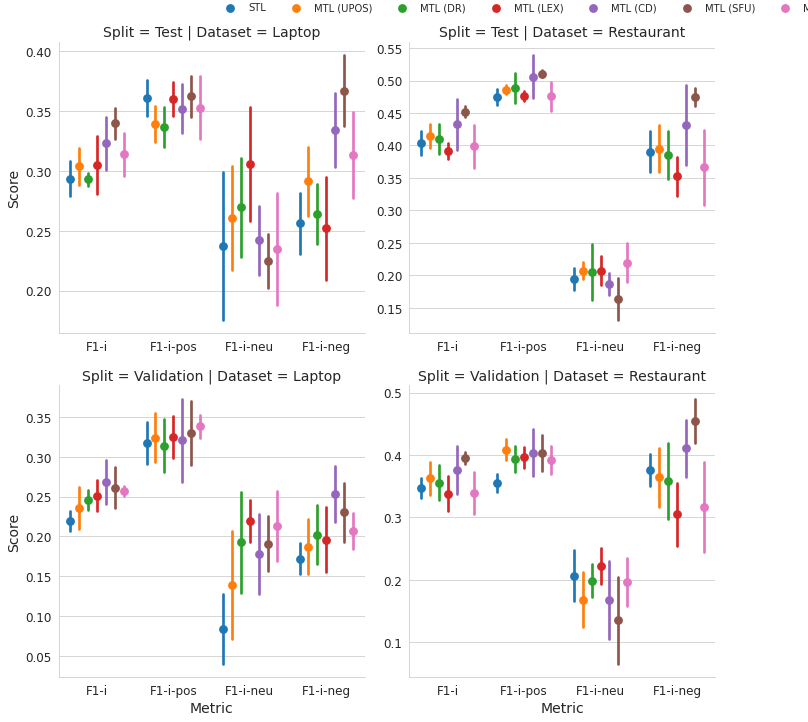

In [4]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = negation_results_df[negation_results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=f1_i_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-a

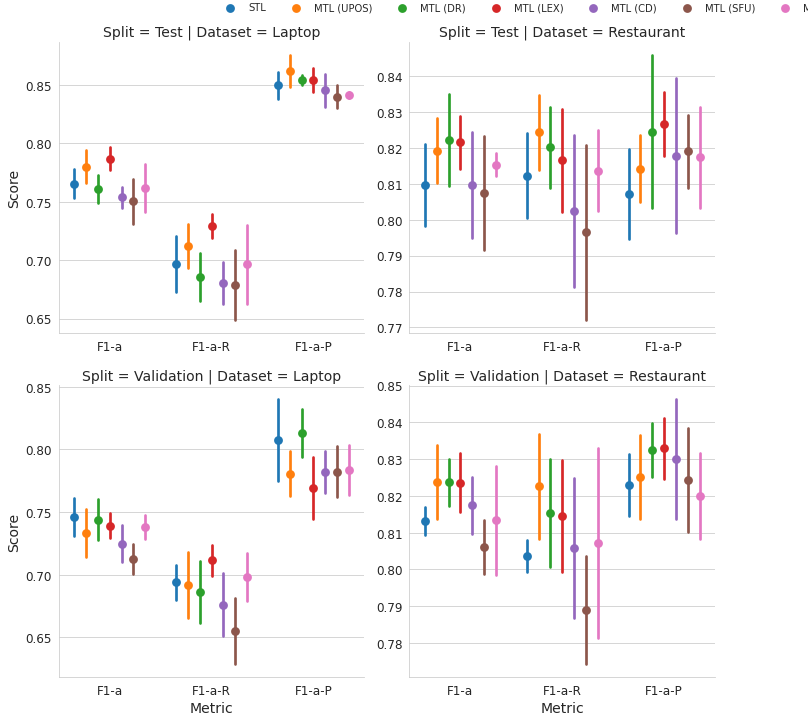

In [5]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = negation_results_df[negation_results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-s and Acc-s

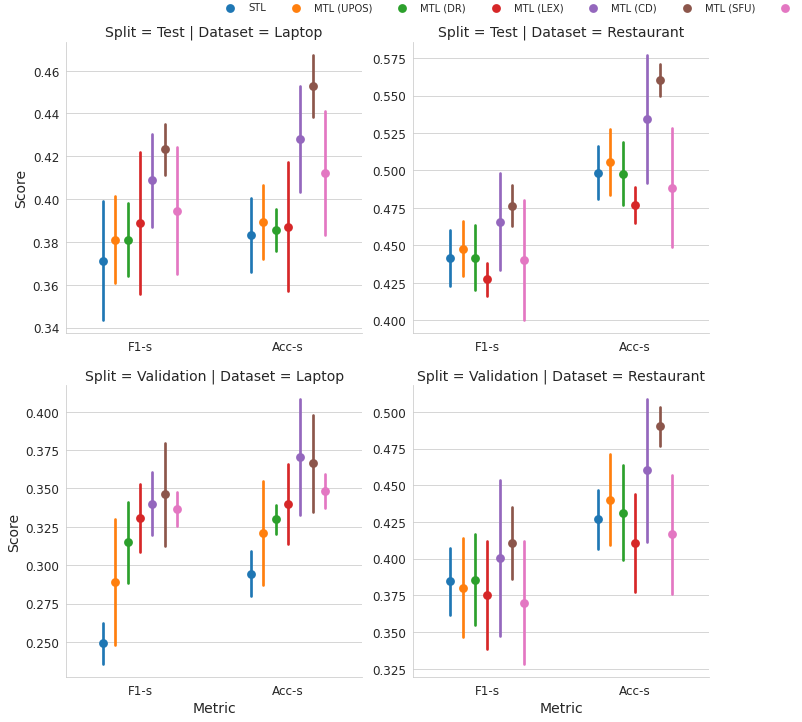

In [6]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = negation_results_df[negation_results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### Headline Metric

These are the metrics that are shown in the paper and those that are the most important:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S

To fit the graphs within the paper we also construct them individually for the test and validation results:

#### Validation Results

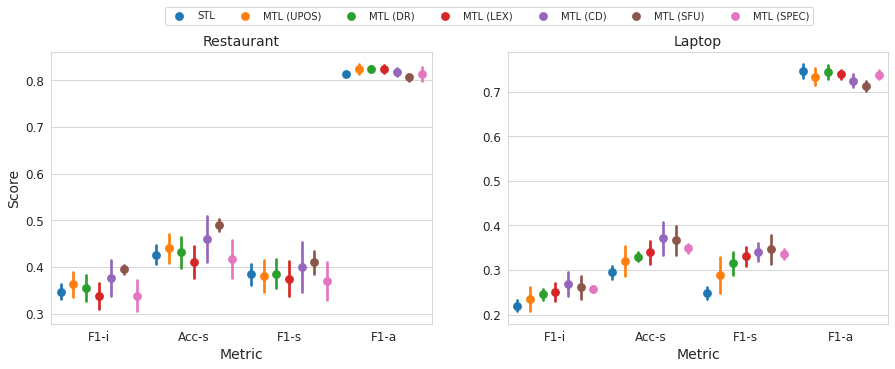

In [7]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
headline_results = negation_results_df[negation_results_df['Metric'].isin(headline_metric_order)]
validation_headline_results = headline_results[headline_results['Split']=='Validation']
_ = create_twin_plot(validation_headline_results)

##### Test Results

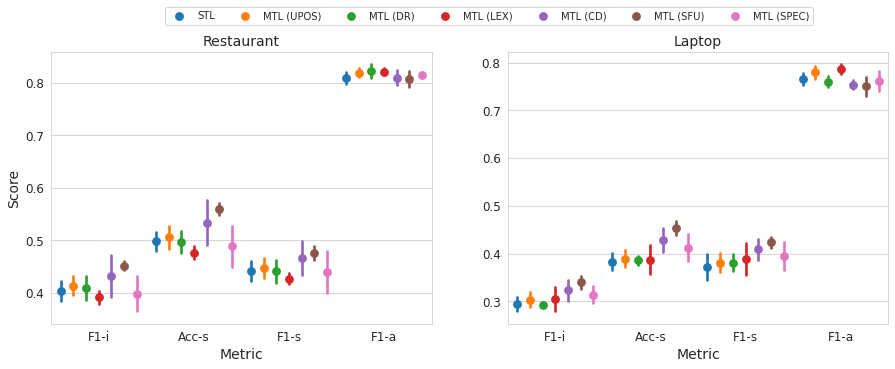

In [8]:
test_headline_results = headline_results[headline_results['Split']=='Test']
_ = create_twin_plot(test_headline_results)

### Statistical Significance

As we can see from the above headline results the MTL models tend to perform better than the STL models. Therefore here we show the P-Values to determine how confident we are the MTL models are better than the STL models:

#### Validation

In [9]:
validation_p_value_results = create_p_value_results(validation_headline_results, keep_raw_p_value=True)
validation_p_value_results = p_value_compared_to_stl(validation_p_value_results)
pd.pivot_table(validation_p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop        0.0062    0.0025  ...      0.0002      0.1048
       Restaurant    0.1291    0.4105  ...      0.6673      0.2464
F1-a   Laptop        0.8875    0.6571  ...      0.8274      0.8875
       Restaurant    0.1125    0.0398  ...      0.4464      0.1125
F1-i   Laptop        0.0216    0.0398  ...      0.0216      0.2501
       Restaurant    0.1726    0.2501  ...      0.7499      0.2501
F1-s   Laptop        0.0216    0.0216  ...      0.0216      0.0216
       Restaurant    0.2501    0.3429  ...      0.7499      0.7499

[8 rows x 6 columns]

#### Test

In [10]:
test_p_value_results = create_p_value_results(test_headline_results, keep_raw_p_value=True)
test_p_value_results = p_value_compared_to_stl(test_p_value_results)
pd.pivot_table(test_p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop        0.0103    0.4170  ...      0.0657      0.3182
       Restaurant    0.0911    0.5212  ...      0.6695      0.3125
F1-a   Laptop        0.8875    0.6571  ...      0.5536      0.0398
       Restaurant    0.5536    0.1125  ...      0.2501      0.0690
F1-i   Laptop        0.0216    0.7499  ...      0.0690      0.1726
       Restaurant    0.0690    0.3429  ...      0.5536      0.4464
F1-s   Laptop        0.0216    0.4464  ...      0.1726      0.2501
       Restaurant    0.0690    0.5536  ...      0.5536      0.4464

[8 rows x 6 columns]

## CWR

In [11]:
all_cwr_negation_results_df = pd.DataFrame(get_negated_data(True, cwr=True))
cwr_negation_results_df = all_cwr_negation_results_df[all_cwr_negation_results_df['Dataset'] != 'MAMS']
not_metric_cols = ['Model', 'Dataset', 'Run', 'Split', 'CWR']
metric_cols = [col_name for col_name in cwr_negation_results_df.columns.tolist() 
               if col_name not in not_metric_cols]
cwr_negation_results_df = pd.melt(cwr_negation_results_df, id_vars=not_metric_cols, 
                                  value_vars=metric_cols, var_name='Metric', 
                                  value_name='Score')
cwr_negation_results_df.head()

,Model,Dataset,Run,Split,CWR,Metric,Score
0,STL,Restaurant,0,Validation,True,F1-a,0.863884
1,STL,Restaurant,1,Validation,True,F1-a,0.856089
2,STL,Restaurant,2,Validation,True,F1-a,0.842676
3,STL,Restaurant,3,Validation,True,F1-a,0.838235
4,STL,Restaurant,4,Validation,True,F1-a,0.841155


### F1-i

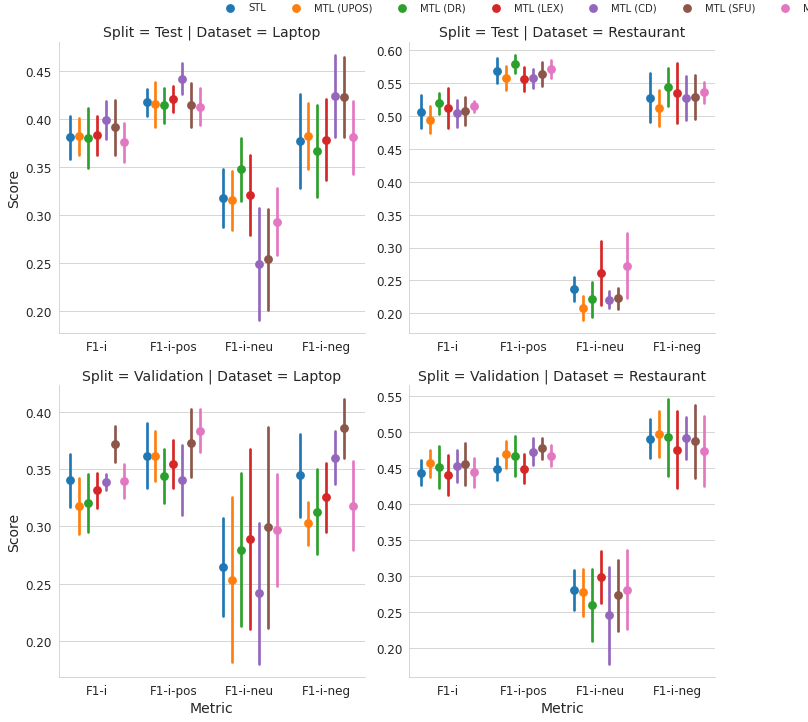

In [12]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = cwr_negation_results_df[cwr_negation_results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=f1_i_results, hue='Model', row='Split', 
               col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-a

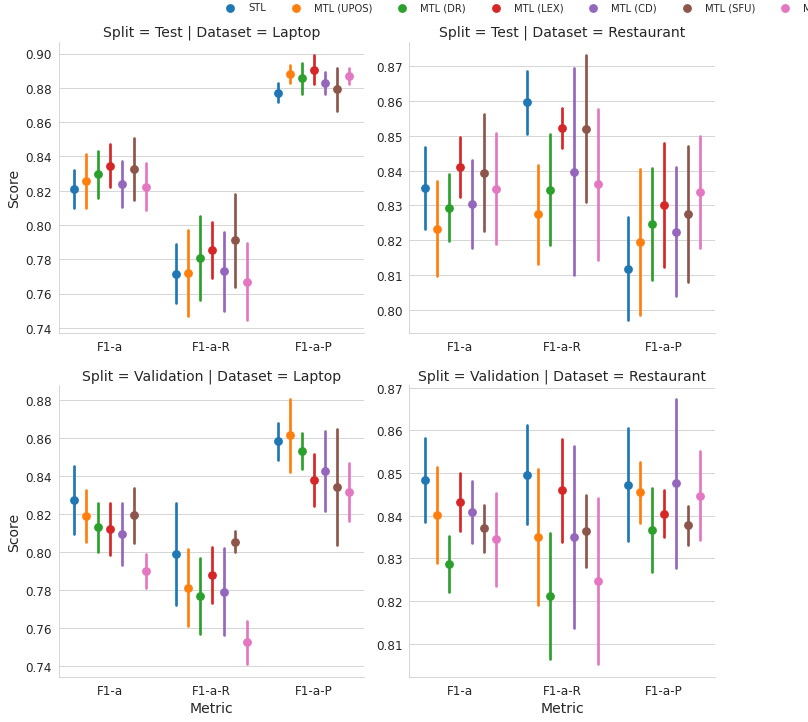

In [13]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = cwr_negation_results_df[cwr_negation_results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-s and Acc-s

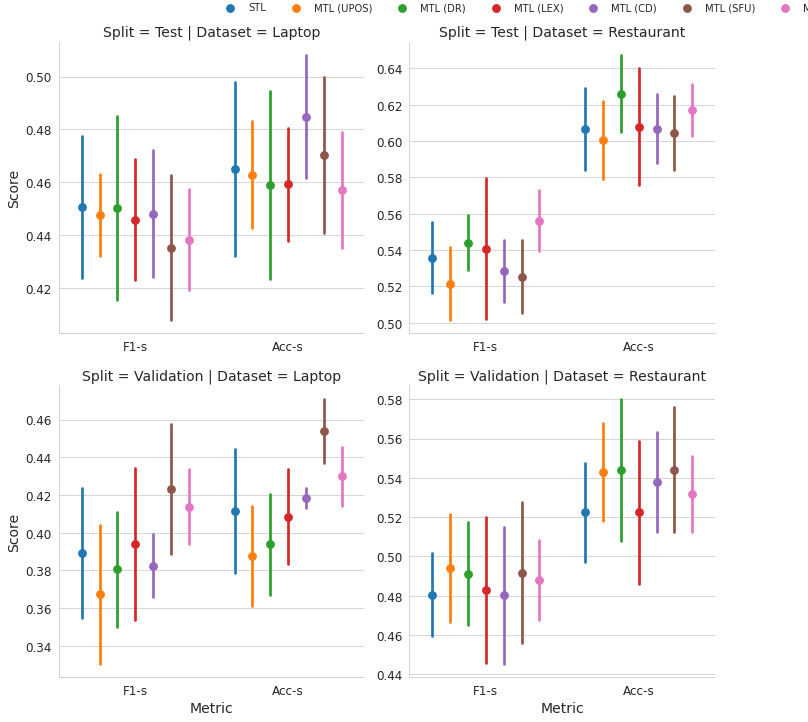

In [14]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = cwr_negation_results_df[cwr_negation_results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', row='Split', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### Headline Metric

These are the metrics that are shown in the paper and those that are the most important:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S

To fit the graphs within the paper we also construct them individually for the test and validation results:

#### Validation Results

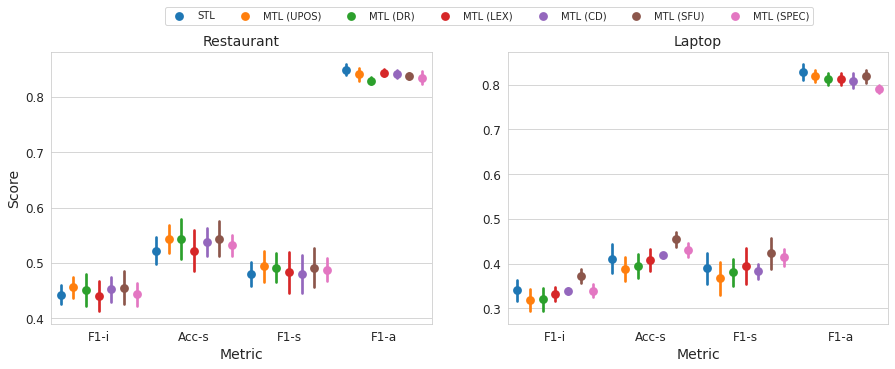

In [15]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
cwr_headline_results = cwr_negation_results_df[cwr_negation_results_df['Metric'].isin(headline_metric_order)]
cwr_validation_headline_results = cwr_headline_results[cwr_headline_results['Split']=='Validation']
_ = create_twin_plot(cwr_validation_headline_results)

#### Test Results

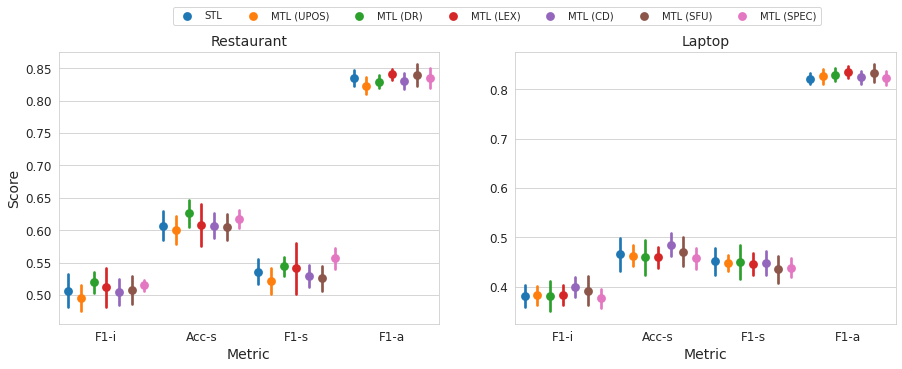

In [16]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
cwr_test_headline_results = cwr_headline_results[cwr_headline_results['Split']=='Test']
_ = create_twin_plot(cwr_test_headline_results)

### Statistical Significance

As we can see from the above headline results the MTL models tend to perform better than the STL models. Therefore here we show the P-Values to determine how confident we are the MTL models are better than the STL models:

#### Validation

In [17]:
cwr_validation_p_value_results = create_p_value_results(cwr_validation_headline_results, 
                                                        keep_raw_p_value=True)
cwr_validation_p_value_results = p_value_compared_to_stl(cwr_validation_p_value_results)
pd.pivot_table(cwr_validation_p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop        0.3478    0.7856  ...      0.1742      0.8539
       Restaurant    0.2078    0.1816  ...      0.2907      0.1389
F1-a   Laptop        0.8274    0.8875  ...      0.9784      0.6571
       Restaurant    0.8274    0.9784  ...      0.8875      0.8875
F1-i   Laptop        0.3429    0.8274  ...      0.4464      0.9310
       Restaurant    0.1125    0.2501  ...      0.4464      0.1125
F1-s   Laptop        0.4464    0.5536  ...      0.0690      0.8875
       Restaurant    0.5536    0.1726  ...      0.2501      0.0690

[8 rows x 6 columns]

#### Test

In [18]:
cwr_test_p_value_results = create_p_value_results(cwr_test_headline_results, 
                                                  keep_raw_p_value=True)
cwr_test_p_value_results = p_value_compared_to_stl(cwr_test_p_value_results)
pd.pivot_table(cwr_test_p_value_results, index=['Metric', 'Dataset'], 
               columns=['Model'], values='P Value').round(4)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Model              MTL (CD)  MTL (DR)  ...  MTL (SPEC)  MTL (UPOS)
Metric Dataset                         ...                        
Acc-s  Laptop        0.1787    0.5955  ...      0.6497      0.5412
       Restaurant    0.4931    0.1199  ...      0.2298      0.6461
F1-a   Laptop        0.4464    0.3429  ...      0.4464      0.3429
       Restaurant    0.9784    0.8875  ...      0.3429      0.8274
F1-i   Laptop        0.3429    0.5536  ...      0.5536      0.3429
       Restaurant    0.5536    0.2501  ...      0.3429      0.8875
F1-s   Laptop        0.3429    0.4464  ...      0.7499      0.4464
       Restaurant    0.8274    0.3429  ...      0.0398      0.9784

[8 rows x 6 columns]

# Comparing GloVe and CWR model results

Below we plot the GloVe and CWR model results for the **F1-i**, **Acc-s**, and **F1-a** metrics:

Validation:

In [19]:
combined_results = pd.concat([negation_results_df, cwr_negation_results_df])
combined_results = combined_results[combined_results['Metric'].isin(['F1-i', 'F1-s', 'Acc-s', 'F1-a'])]
combined_validation_results = combined_results[combined_results['Split']=='Validation']
pd.pivot_table(combined_validation_results, values='Score', columns='Model', 
               index=['Dataset', 'Metric','CWR'], aggfunc=mean_std)

Model                        MTL (CD)      MTL (DR)  ...    MTL (UPOS)           STL
Dataset    Metric CWR                                ...                            
Laptop     Acc-s  False  37.07 (3.78)  32.99 (0.96)  ...  32.09 (3.41)  29.45 (1.46)
                  True   41.84 (0.54)  39.38 (2.69)  ...  38.77 (2.64)  41.15 (3.28)
           F1-a   False  72.49 (1.45)  74.40 (1.64)  ...  73.33 (1.90)  74.60 (1.51)
                  True   80.94 (1.64)  81.31 (1.29)  ...  81.92 (1.36)  82.75 (1.80)
           F1-i   False  26.87 (2.75)  24.56 (1.21)  ...  23.54 (2.66)  21.98 (1.26)
                  True   33.86 (0.71)  32.04 (2.54)  ...  31.78 (2.46)  34.01 (2.29)
           F1-s   False  34.02 (2.05)  31.48 (2.66)  ...  28.92 (4.11)  24.92 (1.33)
                  True   38.26 (1.67)  38.05 (3.06)  ...  36.73 (3.67)  38.92 (3.45)
Restaurant Acc-s  False  46.02 (4.88)  43.13 (3.24)  ...  44.02 (3.09)  42.69 (2.01)
                  True   53.79 (2.56)  54.40 (3.63)  ...  54.31 (2.49)  52.25 (2.51)
           F1-a   False  81.74 (0.77)  82.37 (0.64)  ...  82.38 (1.00)  81.32 (0.37)
                  True   84.08 (0.72)  82.87 (0.66)  ...  84.02 (1.12)  84.84 (0.99)
           F1-i   False  37.61 (3.86)  35.54 (2.81)  ...  36.27 (2.64)  34.71 (1.58)
                  True   45.23 (2.19)  45.07 (2.90)  ...  45.62 (1.88)  44.31 (1.74)
           F1-s   False  40.03 (5.30)  38.56 (3.10)  ...  38.03 (3.40)  38.45 (2.28)
                  True   48.03 (3.48)  49.13 (2.62)  ...  49.42 (2.76)  48.06 (2.12)

[16 rows x 7 columns]

Test:

In [20]:
combined_test_results = combined_results[combined_results['Split']=='Test']
pd.pivot_table(combined_test_results, values='Score', columns='Model', 
               index=['Dataset', 'Metric','CWR'], aggfunc=mean_std)

Model                        MTL (CD)      MTL (DR)  ...    MTL (UPOS)           STL
Dataset    Metric CWR                                ...                            
Laptop     Acc-s  False  42.80 (2.48)  38.54 (0.98)  ...  38.92 (1.74)  38.32 (1.73)
                  True   48.49 (2.32)  45.90 (3.54)  ...  46.29 (2.03)  46.50 (3.30)
           F1-a   False  75.36 (0.91)  76.05 (1.20)  ...  77.98 (1.41)  76.52 (1.24)
                  True   82.39 (1.34)  82.95 (1.36)  ...  82.58 (1.58)  82.10 (1.11)
           F1-i   False  32.28 (2.23)  29.30 (0.54)  ...  30.36 (1.56)  29.33 (1.47)
                  True   39.95 (2.02)  38.08 (3.13)  ...  38.23 (1.89)  38.14 (2.23)
           F1-s   False  40.88 (2.17)  38.11 (1.71)  ...  38.11 (2.02)  37.13 (2.78)
                  True   44.81 (2.40)  45.05 (3.47)  ...  44.77 (1.54)  45.08 (2.68)
Restaurant Acc-s  False  53.41 (4.28)  49.78 (2.10)  ...  50.58 (2.18)  49.86 (1.77)
                  True   60.69 (1.91)  62.61 (2.11)  ...  60.06 (2.13)  60.66 (2.24)
           F1-a   False  80.97 (1.47)  82.22 (1.29)  ...  81.92 (0.91)  80.97 (1.14)
                  True   83.04 (1.26)  82.94 (0.97)  ...  82.33 (1.37)  83.50 (1.16)
           F1-i   False  43.28 (3.95)  40.95 (2.31)  ...  41.43 (1.87)  40.38 (1.82)
                  True   50.40 (2.03)  51.92 (1.64)  ...  49.45 (2.01)  50.68 (2.52)
           F1-s   False  46.58 (3.24)  44.16 (2.18)  ...  44.78 (1.85)  44.14 (1.89)
                  True   52.85 (1.69)  54.41 (1.51)  ...  52.16 (2.01)  53.59 (1.95)

[16 rows x 7 columns]

# Extras

Below we show the statistical significance between each model. These heatmaps show whether or not the model in the X-axis is significantly better than the model on the Y-axis with a confidence of at least 95%.

## Statistical Tests for all the GloVe models

These are all of the significance results for the GloVe based models.

### F1-i

Validation:

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


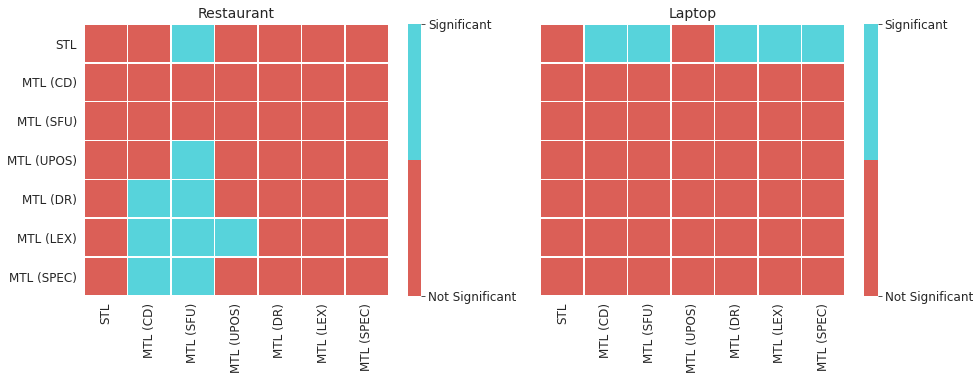

In [21]:
validation_p_value_results = create_p_value_results(validation_headline_results, p_value_threshold=0.05)
_ = create_stats_heatmap(validation_p_value_results, metric='F1-i')

Test:

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


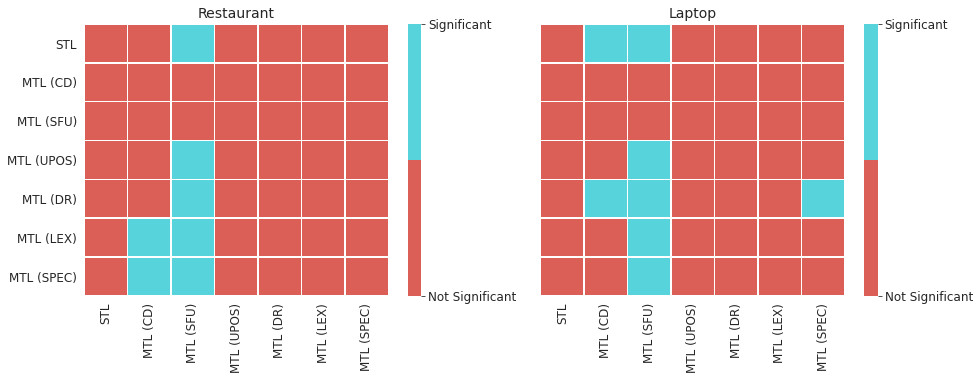

In [22]:
test_p_value_results = create_p_value_results(test_headline_results, p_value_threshold=0.05)
_ = create_stats_heatmap(test_p_value_results, metric='F1-i')

#### F1-a

Validation:

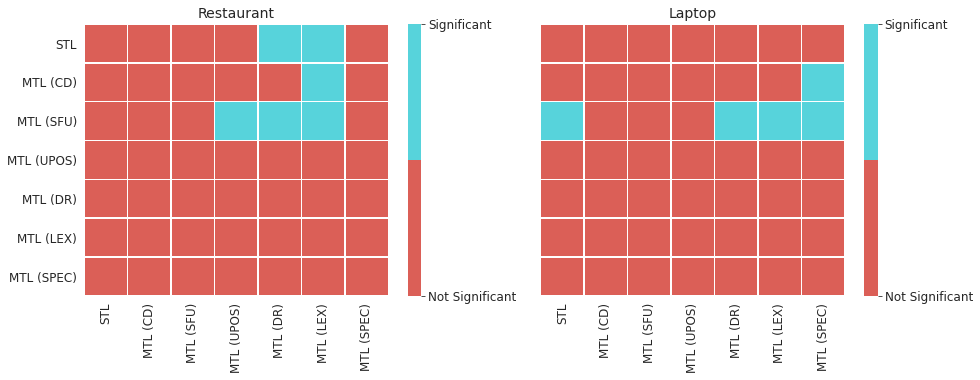

In [23]:
_ = create_stats_heatmap(validation_p_value_results, metric='F1-a')

Test:

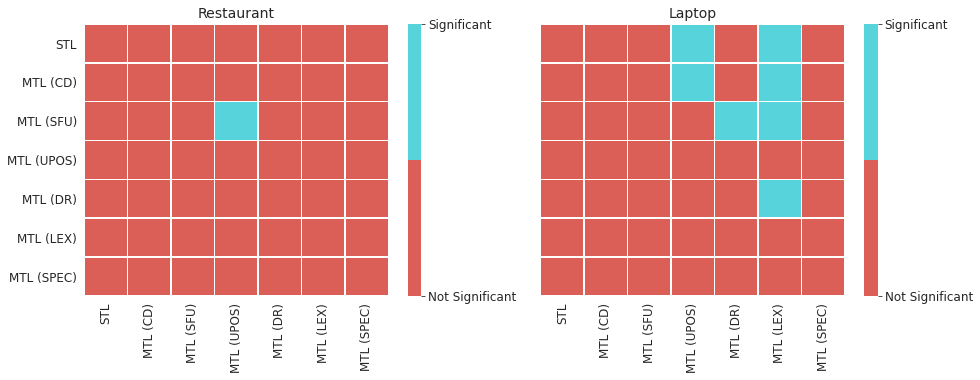

In [24]:
_ = create_stats_heatmap(test_p_value_results, metric='F1-a')

#### F1-s

Validation:

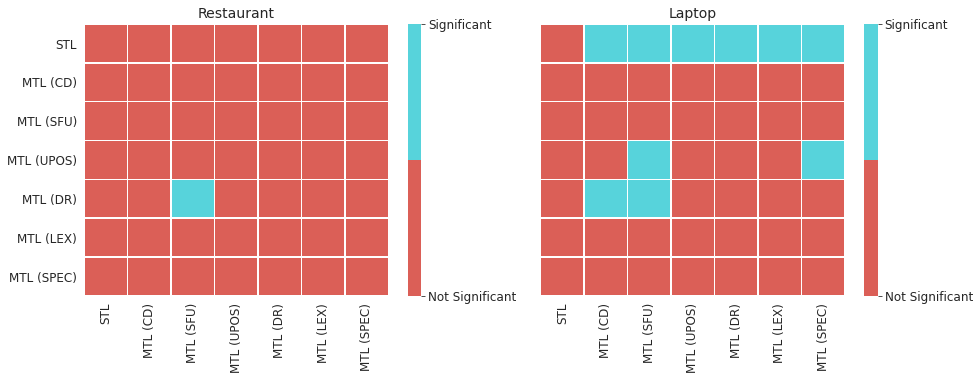

In [25]:
_ = create_stats_heatmap(validation_p_value_results, metric='F1-s')

Test:

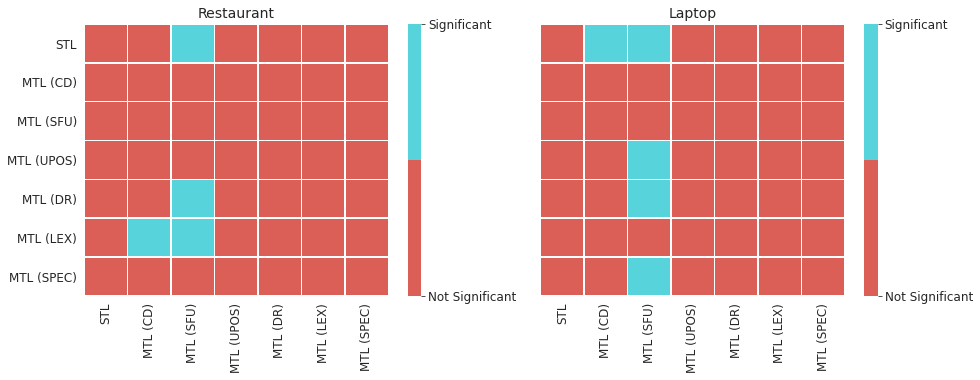

In [26]:
_ = create_stats_heatmap(test_p_value_results, metric='F1-s')

#### Acc-s

Validation:

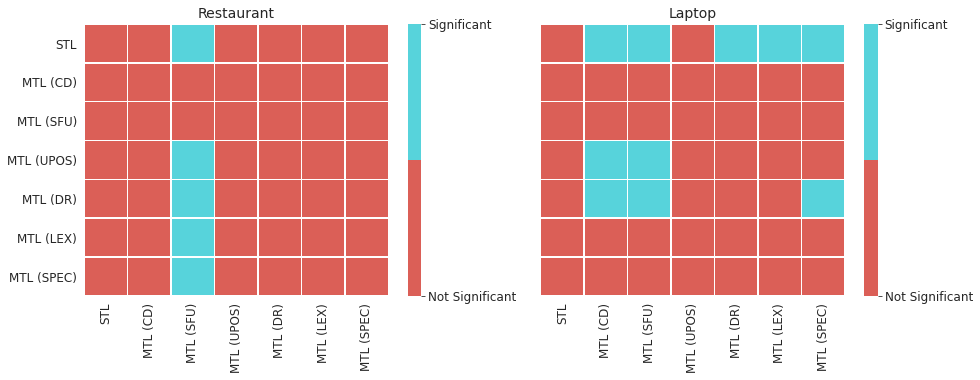

In [27]:
_ = create_stats_heatmap(validation_p_value_results, metric='Acc-s')

Test:

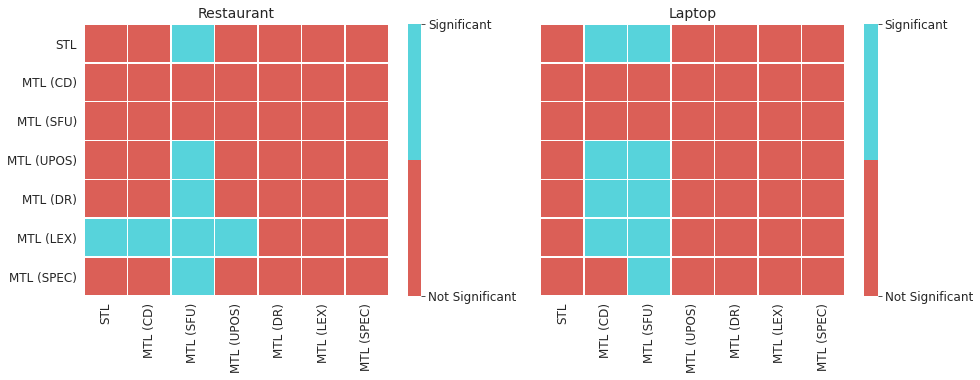

In [28]:
_ = create_stats_heatmap(test_p_value_results, metric='Acc-s')

## Statistical Tests for all the CWR models

These are all of the significance results for the CWR based models.

### F1-i

Validation:

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


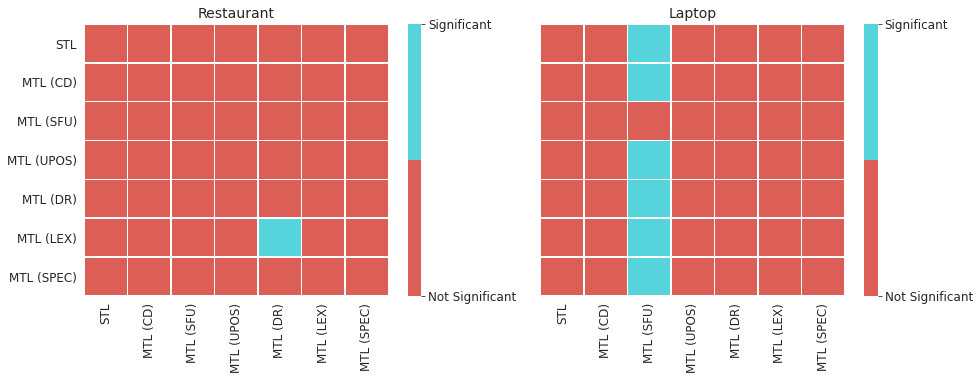

In [29]:
cwr_validation_p_value_results = create_p_value_results(cwr_validation_headline_results, 
                                                        p_value_threshold=0.05)
_ = create_stats_heatmap(cwr_validation_p_value_results, metric='F1-i')

Test:

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


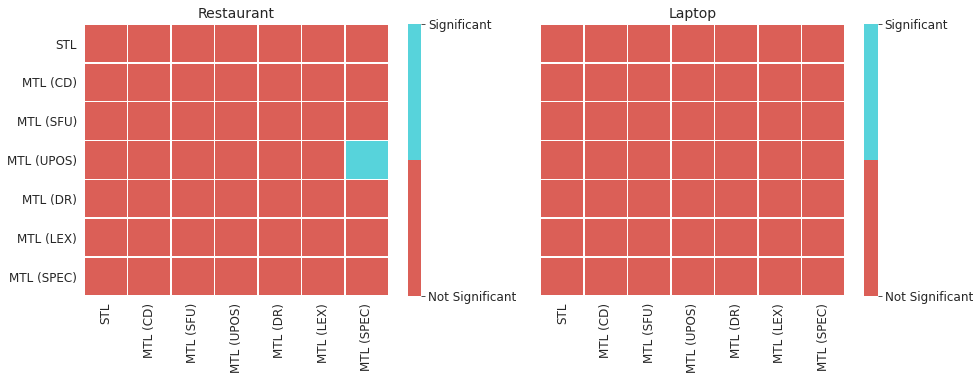

In [30]:
cwr_test_p_value_results = create_p_value_results(cwr_test_headline_results, 
                                                  p_value_threshold=0.05)
_ = create_stats_heatmap(cwr_test_p_value_results, metric='F1-i')

### F1-a

Validation:

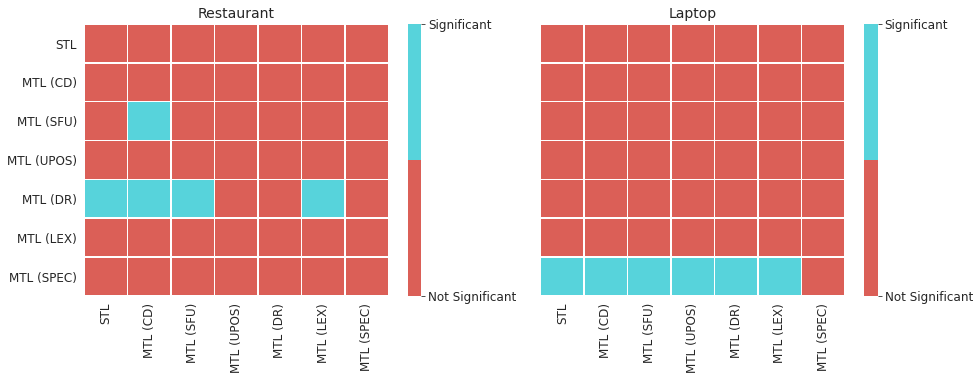

In [31]:
_ = create_stats_heatmap(cwr_validation_p_value_results, metric='F1-a')

Test:

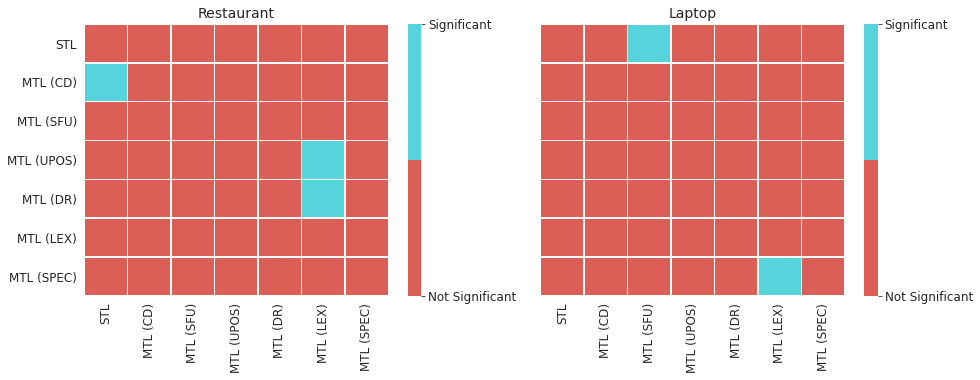

In [32]:
_ = create_stats_heatmap(cwr_test_p_value_results, metric='F1-a')

### F1-s

Validation:

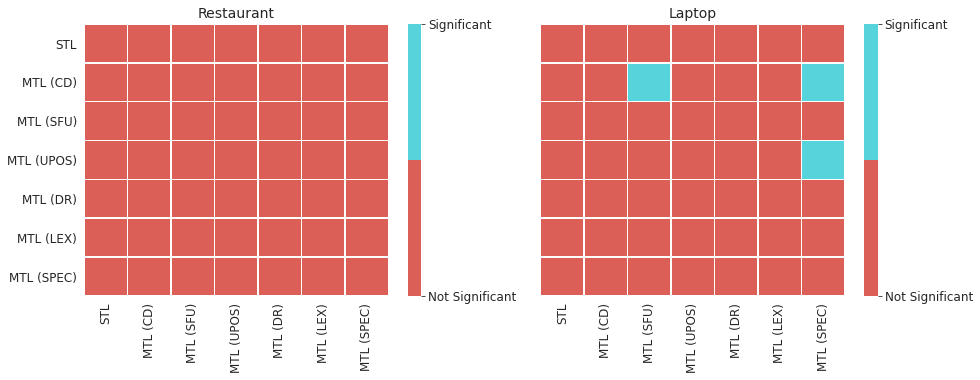

In [33]:
_ = create_stats_heatmap(cwr_validation_p_value_results, metric='F1-s')

Test:

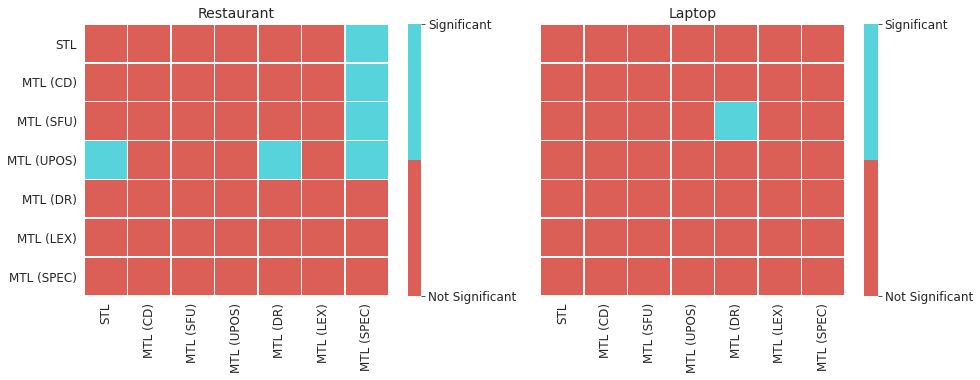

In [34]:
_ = create_stats_heatmap(cwr_test_p_value_results, metric='F1-s')

### Acc-s

Validation:

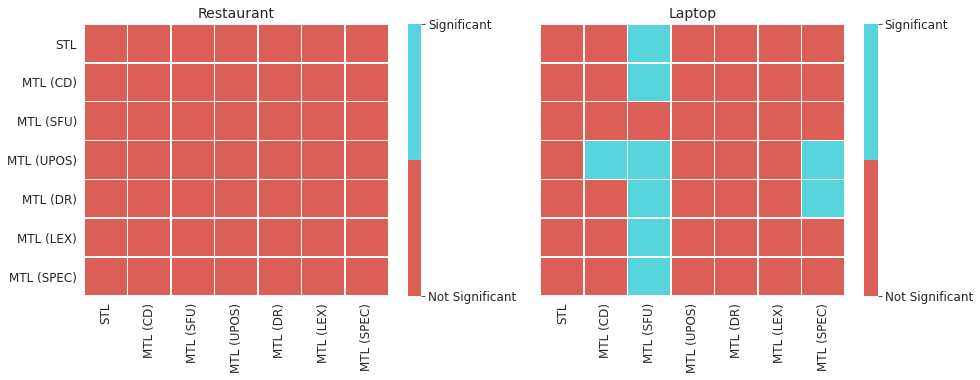

In [35]:
_ = create_stats_heatmap(cwr_validation_p_value_results, metric='Acc-s')

Test:

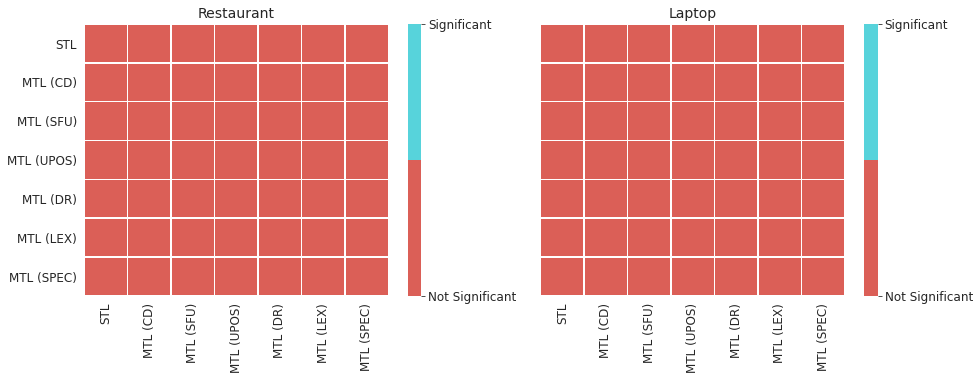

In [36]:
_ = create_stats_heatmap(cwr_test_p_value_results, metric='Acc-s')